# 02 - Exploratory Data Analysis

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

In [20]:
sns.set_context('notebook')
sns.set_palette('deep')
#sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

### Aux. Functions

In [3]:
def subset_flights(df, orig='all', dest='all', dDate='all', dTime='all', flight_no='all'):
    if orig != 'all':
        df = df[df['flyFrom'] == orig]
    if dest != 'all':
        df = df[df['flyTo'] == dest]
    if dDate != 'all':
        df = df[df['dDate'] == dDate]
    if dTime != 'all':
        df = df[df['dTime'] == dTime]
    if flight_no != 'all':
        df = df[df['flight_no'] == flight_no]
        
    return df

In [4]:
def subset_by_route(df, route):
    if type(route) is str:
        orig = route.split('-')[0]
        dest = route.split('-')[1]
    else:
        orig = route[0]
        dest = route[1]
    df = df[(df['flyFrom'] == orig) & (df['flyTo'] == dest)]
    return df

In [92]:
def plot_hist_price_by_route(df, log=True):
    df = df.copy()
    routes = df['flyFrom'] +'-'+ df['flyTo']
    routes = routes.unique()
    if log:
        df['price'] = np.log(df['price'])
    f, axes = plt.subplots(2, 5, figsize=(15,9));
    axes = axes.ravel();
    for idx, route in enumerate(routes):
        df_route = subset_by_route(df,route)
        sns.histplot(df_route['price'], kde=False, ax=axes[idx], bins=50);
        axes[idx].set_title(route)
    plt.tight_layout()
        

### Load data

In [5]:
flights = pd.read_csv('../data/interim/flights_interim.csv')

In [6]:
flights.head()

,collectionDate,dDate,dTime,aDate,aTime,dTimeUTC,aTimeUTC,flyFrom,flyTo,airlines,...,distance,route,price,seats,cityFrom,cityCodeFrom,cityTo,cityCodeTo,countryFrom,countryTo
0,2021-01-31,2021-02-01,15:00,2021-02-01,16:25,2021-02-01 14:00:00,2021-02-01 15:25:00,MAD,BCN,UX,...,483.25,MAD -> BCN,78,NaN,Madrid,MAD,Barcelona,BCN,Spain,Spain
1,2021-01-31,2021-02-01,09:35,2021-02-01,10:50,2021-02-01 08:35:00,2021-02-01 09:50:00,MAD,BCN,VY,...,483.25,MAD -> BCN,91,NaN,Madrid,MAD,Barcelona,BCN,Spain,Spain
2,2021-01-31,2021-02-01,19:45,2021-02-01,21:05,2021-02-01 18:45:00,2021-02-01 20:05:00,MAD,BCN,IB,...,483.25,MAD -> BCN,91,5.0,Madrid,MAD,Barcelona,BCN,Spain,Spain
3,2021-01-31,2021-02-01,19:15,2021-02-02,08:50,2021-02-01 18:15:00,2021-02-02 07:50:00,MAD,BCN,UX,...,483.25,MAD -> BCN,108,3.0,Madrid,MAD,Barcelona,BCN,Spain,Spain
4,2021-01-31,2021-02-01,14:50,2021-02-02,08:50,2021-02-01 13:50:00,2021-02-02 07:50:00,MAD,BCN,UX,...,483.25,MAD -> BCN,112,3.0,Madrid,MAD,Barcelona,BCN,Spain,Spain


In [8]:
# Data transformations needed for some visualization:
flights['orig-dest'] = flights['flyFrom'] +'-'+ flights['flyTo']
flights['airline'] = flights['airlines'].apply(lambda x: x.split(',')[0])
flights['flight_no'] = flights['airline']+''+flights['flight_no'].astype(str)

In [50]:
departure_dates = pd.to_datetime(flights['dDate'])
max_collection_day = pd.to_datetime(flights['collectionDate']).max()                    
pf = flights[departure_dates <= max_collection_day]

In [ ]:
flights.groupby()

### Features Overview

In [61]:
flights.columns

Index(['collectionDate', 'dDate', 'dTime', 'aDate', 'aTime', 'dTimeUTC',
       'aTimeUTC', 'flyFrom', 'flyTo', 'airlines', 'flight_no', 'fly_duration',
       'distance', 'route', 'price', 'seats', 'cityFrom', 'cityCodeFrom',
       'cityTo', 'cityCodeTo', 'countryFrom', 'countryTo', 'orig-dest',
       'airline'],
      dtype='object')

Target:
* price: Ticket price of a flight

Features:
* **collectionDate**: date flight data was taken
* **dDate**: departure day
* **dTime**: departure time
* **aDate**: arrival day
* **aTime**: arrival time
* **dTimeUTC**, **aTimeUTC**: departure and arrival time in UTC timezone
* **flyFrom**: origin airport IATA code
* **flyTo**: destination airport IATA code
* **airlines**: self-explanatory
* **flight_no**: identification plain number
* **fly_duration**, **distance**: self-explanatory
* **route**: airports through flight passes
* **seats**: availability
* **cityFrom**, **cityCodeFrom**, **cityTo**, **cityCodeTo**: different id's for the origin and destination cities
* **countryFrom**, **countryTo**: origin and dest countries

Numerical: distance, fly_duration, seats, price
\
Categorical: flyFrom, flyTo, airlines, route

In [62]:
flights[['distance', 'fly_duration', 'seats','price']].describe()

,distance,fly_duration,seats,price
count,1.266210e+06,1.266210e+06,973929.000000,1.266210e+06
mean,4.035434e+03,2.124810e+01,2.720383,3.278173e+02
std,3.617889e+03,1.248897e+01,2.420424,4.359747e+02
min,2.021800e+02,7.500000e-01,1.000000,2.000000e+01
25%,1.110280e+03,1.266667e+01,1.000000,1.030000e+02
50%,1.774110e+03,2.066667e+01,1.000000,2.420000e+02
75%,9.075770e+03,2.800000e+01,4.000000,3.840000e+02
max,1.009794e+04,6.000000e+01,8.000000,7.543700e+04


In [13]:
# TODO: comment descriptive statitics when I have final dataset

In [10]:
flights.isna().sum()

collectionDate         0
dDate                  0
dTime                  0
aDate                  0
aTime                  0
dTimeUTC               0
aTimeUTC               0
flyFrom                0
flyTo                  0
airlines               0
flight_no              0
fly_duration           0
distance               0
route                  0
price                  0
seats             292281
cityFrom               0
cityCodeFrom           0
cityTo                 0
cityCodeTo             0
countryFrom            0
countryTo              0
orig-dest              0
airline                0
dtype: int64

## Univariate Analysis

### Price

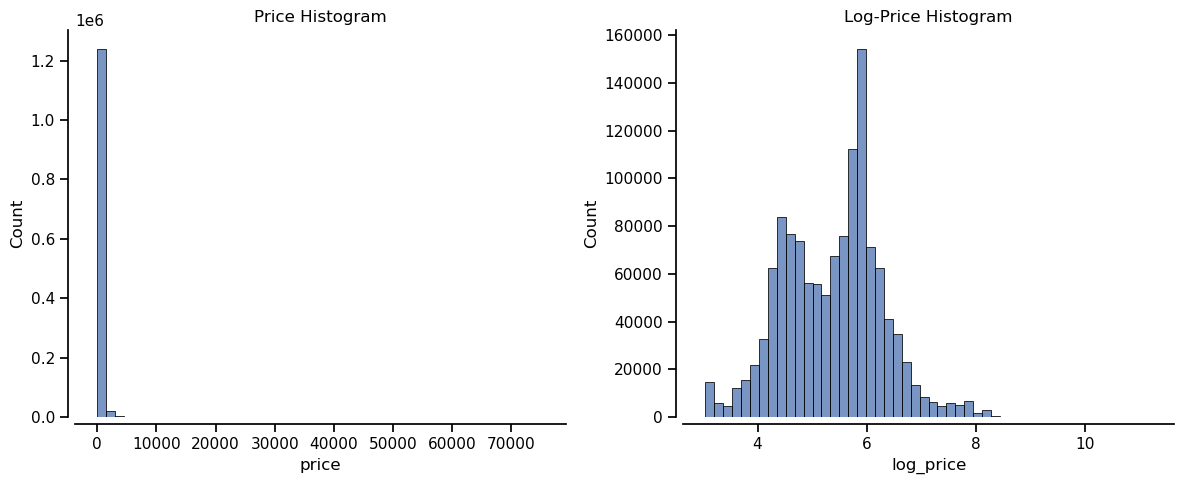

In [37]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

# plot price hist
sns.histplot(x='price', data=flights, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Price Histogram')

# plot log transform price hist
flights['log_price'] = np.log(flights['price'])
sns.histplot(x='log_price', data=flights, kde=False, bins=50, ax=axes[1]);
axes[1].set_title('Log-Price Histogram')

sns.despine(offset=5)
plt.tight_layout()

* Target variable 'price' has many high values that skew to the right its distribution. So let's use log-transform.
* As we can see, 'log_price' aproximate a bit better to a normal distribution 

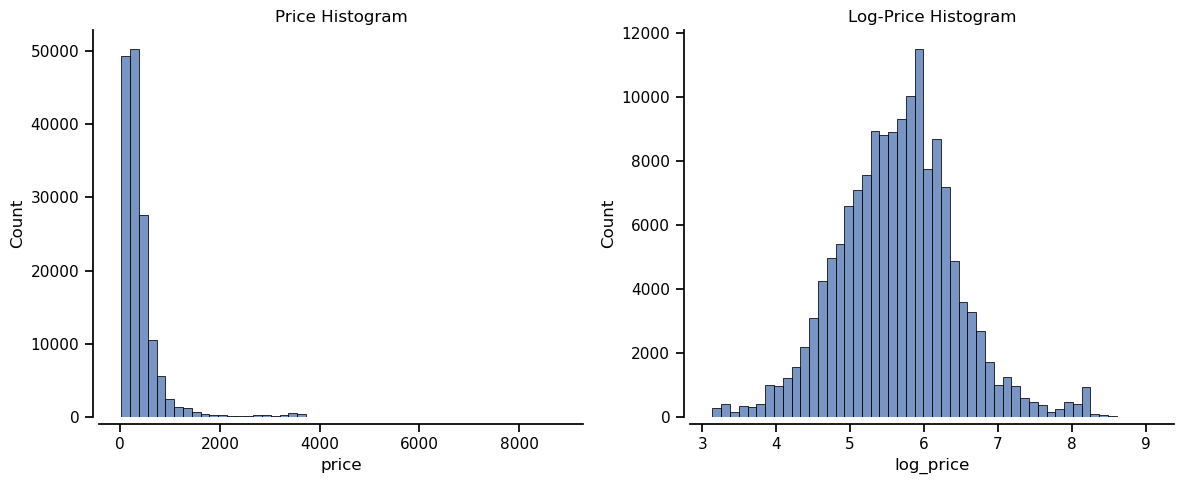

In [51]:
f, axes = plt.subplots(1, 2, figsize=(12,5))

# plot price hist
sns.histplot(x='price', data=pf, kde=False, bins=50, ax=axes[0]);
axes[0].set_title('Price Histogram')

# plot log transform price hist
flights['log_price'] = np.log(flights['price'])
sns.histplot(x='log_price', data=pf, kde=False, bins=50, ax=axes[1]);
axes[1].set_title('Log-Price Histogram')

sns.despine(offset=5)
plt.tight_layout()

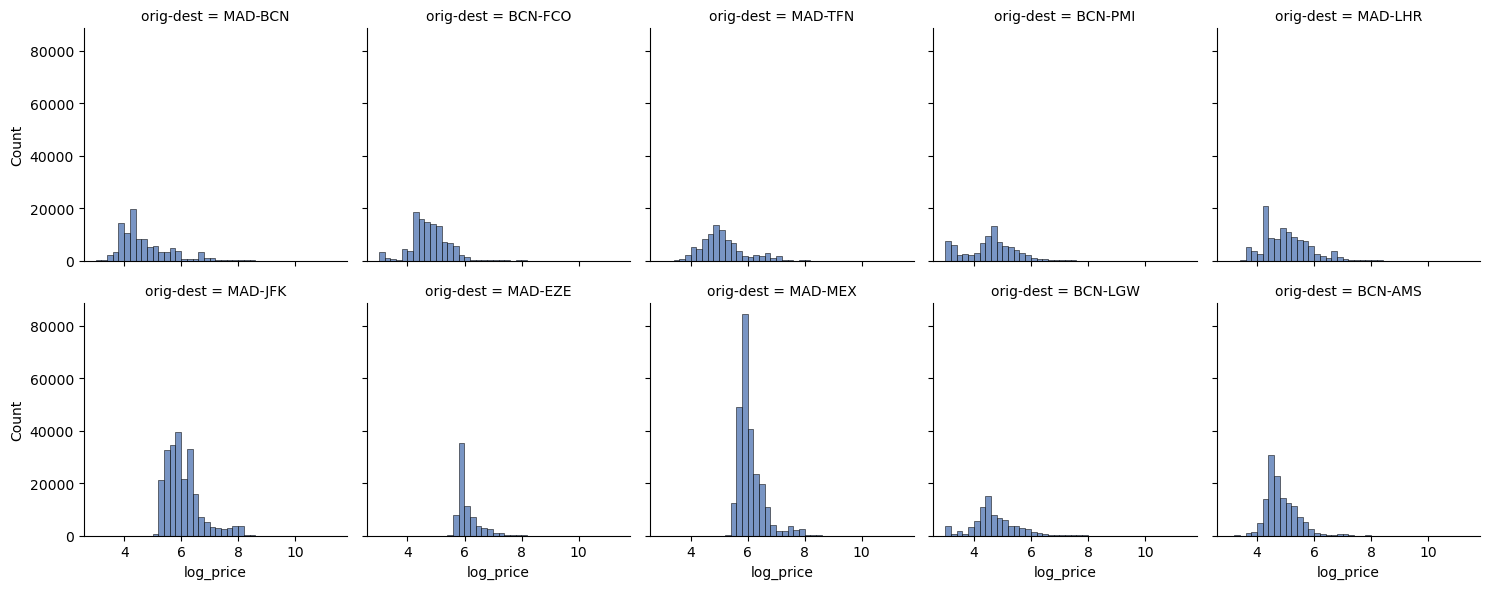

In [13]:
# Price distribution for route
sns.displot(
    flights, x="log_price", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=0.2, height=3
);
plt.tight_layout()

* As we can expected, some routes are more placed to the left (cheaper routes) and other to the right (more expensive routes).
* It seems that long-distance routes as 'MAD-MEX' (Madrid-Mexico) has narrower distribution than short-distance ones. 

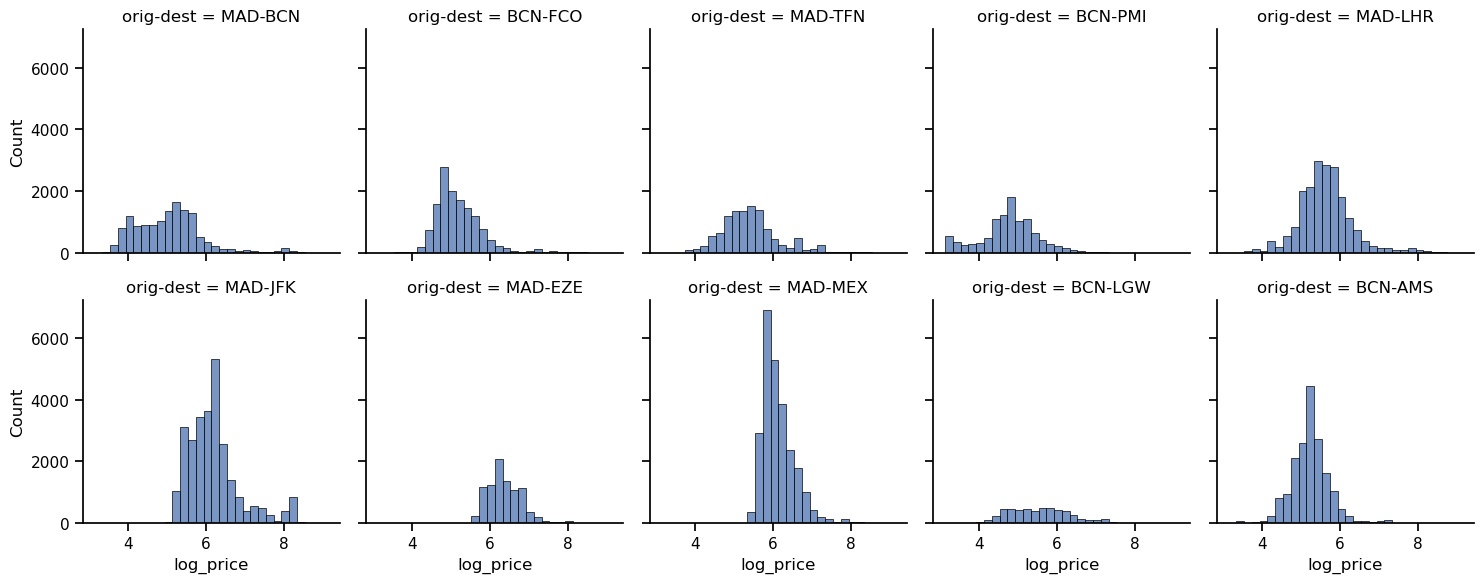

In [212]:
# Price distribution for route
sns.displot(
    pf, x="log_price", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=0.2, height=3
);
plt.tight_layout()

#### Log-Price histogram by route

In [104]:
#plot_hist_price_by_route(flights, log=True);

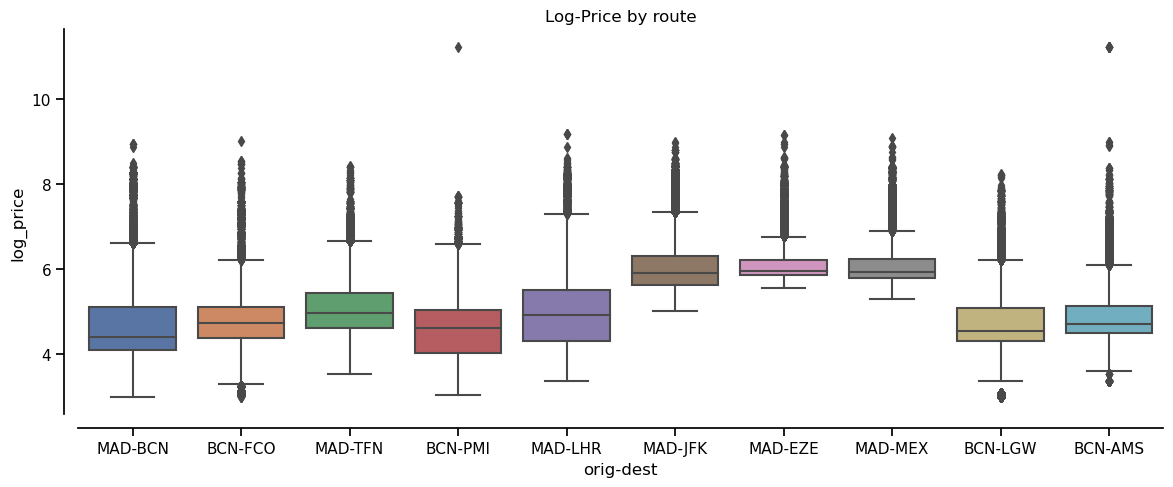

In [58]:
flights['orig-dest'] = flights['flyFrom'] +'-'+ flights['flyTo']
plt.figure(figsize=(14, 5))
sns.boxplot(x='orig-dest', y='log_price', data=flights);
sns.despine(offset=10)
plt.title('Log-Price by route');

* As expected, longest routes have more expensive fares
* Many outliers

In [166]:
pf.groupby(['flyFrom', 'flyTo','dDate', 'dTime', 'aTime', 'flight_no'])[['price']].mean().reset_index()

,flyFrom,flyTo,dDate,dTime,aTime,flight_no,price
0,BCN,AMS,2021-02-01,06:00,08:30,KL1662,163.000000
1,BCN,AMS,2021-02-01,06:20,11:25,AF1449,773.000000
2,BCN,AMS,2021-02-01,06:20,14:00,AF1449,426.000000
3,BCN,AMS,2021-02-01,06:35,13:10,LH1139,532.000000
4,BCN,AMS,2021-02-01,06:35,16:35,LH1139,454.000000
...,...,...,...,...,...,...,...
36894,MAD,TFN,2021-03-02,20:15,21:30,NT8966,311.000000
36895,MAD,TFN,2021-03-02,20:15,21:30,VY8966,227.250000
36896,MAD,TFN,2021-03-02,20:15,22:45,IB8966,452.000000
36897,MAD,TFN,2021-03-02,20:15,22:45,NT8966,397.333333


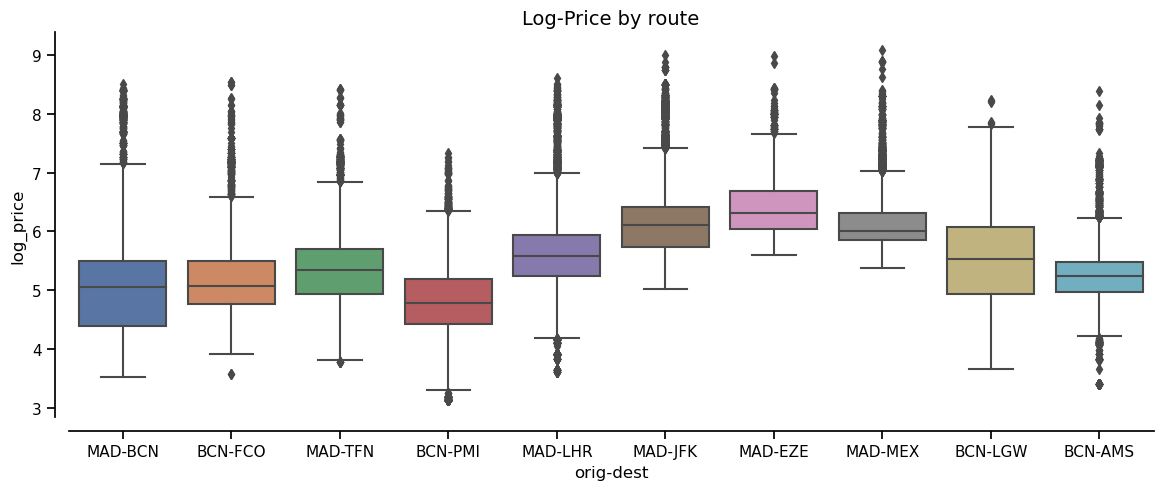

In [176]:
plt.figure(figsize=(14, 5))
sns.boxplot(x='orig-dest', y='log_price', data=pf);
sns.despine(offset=10)
plt.title('Log-Price by route', fontsize=14);

### CollectionDate

In [19]:
flights['collectionDate'].head()

0    2021-01-31
1    2021-01-31
2    2021-01-31
3    2021-01-31
4    2021-01-31
Name: collectionDate, dtype: object

* Day that data was collected. We can use this variable to compute a new 'Days until departure' numerical variable using this column and departure date colunm.

### FlyFrom, FlyTo

We have collected flights from 10 routes:

In [20]:
routes = flights['flyFrom'] +'-'+ flights['flyTo']

In [21]:
routes.unique()

array(['MAD-BCN', 'BCN-FCO', 'MAD-TFN', 'BCN-PMI', 'MAD-LHR', 'MAD-JFK',
       'MAD-EZE', 'MAD-MEX', 'BCN-LGW', 'BCN-AMS'], dtype=object)

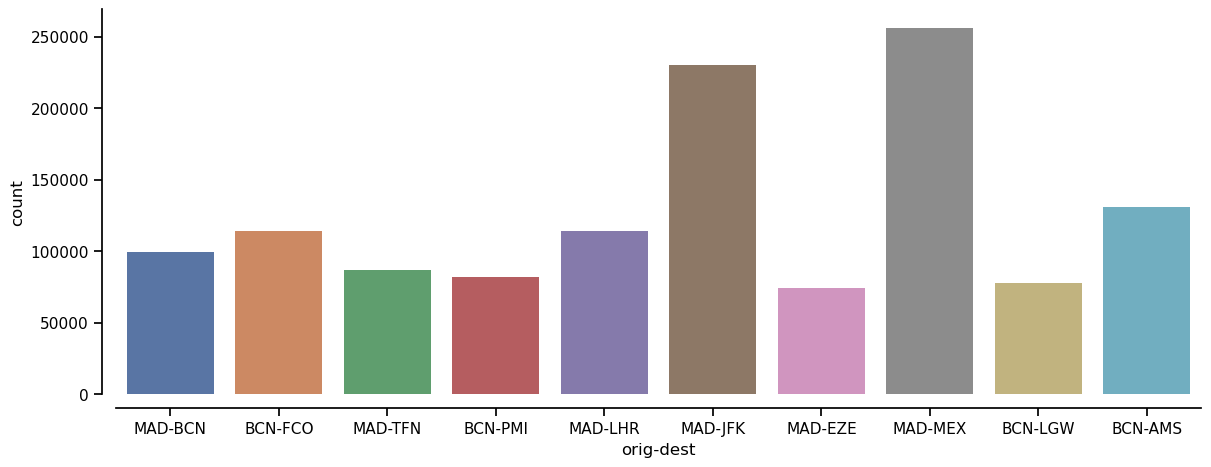

In [66]:
plt.figure(figsize=(14,5))
sns.countplot(x='orig-dest', data=flights)
sns.despine(offset=10);
plt.xticks(rotation=0);

* MAD-JFK (Madrid-New York) and MAD-MEX (Madrid-Mexico City) are the busiest routes. The rest of them have a similar traffic.
* Maybe we can add a new categorical variable with the route. 

In [184]:
# group by flight
pf_agg = pf.groupby(['orig-dest','dDate', 'dTime', 'aTime', 'flight_no'])[['log_price']].mean().reset_index()

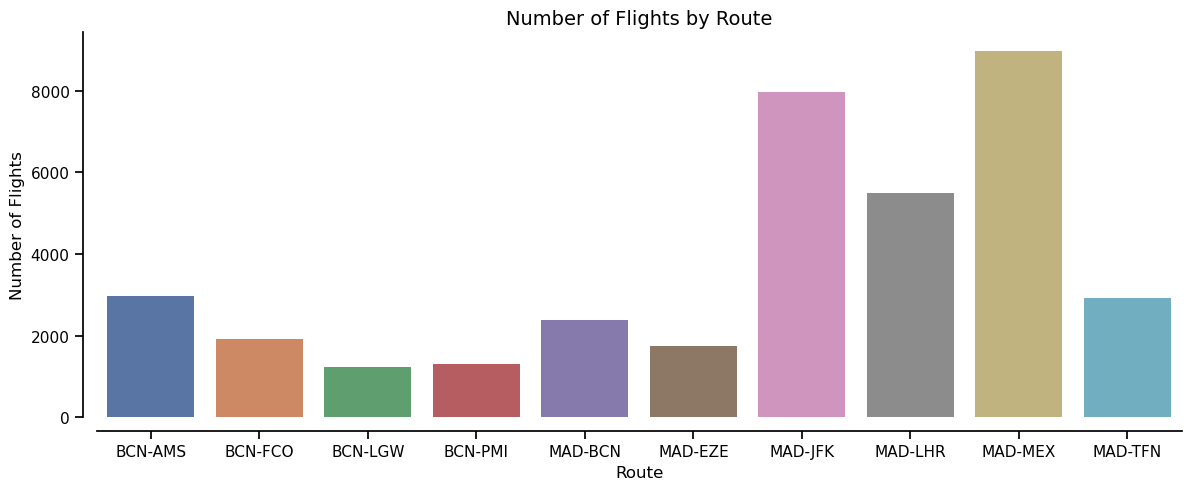

In [185]:
plt.figure(figsize=(14,5))
sns.countplot(x='orig-dest', data=pf_agg)
sns.despine(offset=10);
plt.title('Number of Flights by Route', fontsize=14)
plt.xlabel('Route')
plt.ylabel('Number of Flights')
plt.xticks(rotation=0);

### Airlines

In [23]:
flights[['airlines', 'route']]

,airlines,route
0,UX,MAD -> BCN
1,VY,MAD -> BCN
2,IB,MAD -> BCN
3,UX,MAD -> BCN
4,UX,MAD -> BCN
...,...,...
1266205,TP,BCN->LIS->FCO
1266206,UX,BCN->MAD->FCO
1266207,UX,BCN->MAD->FCO
1266208,TP,BCN->LIS->FCO


* Airlines column show the carrier that manage a given flight. Hopping flights have more than one airline.

In [117]:
flights['airline'].nunique()

131

There are 131 airlines in our dataset. Let's plot the top 40 busiest airline.

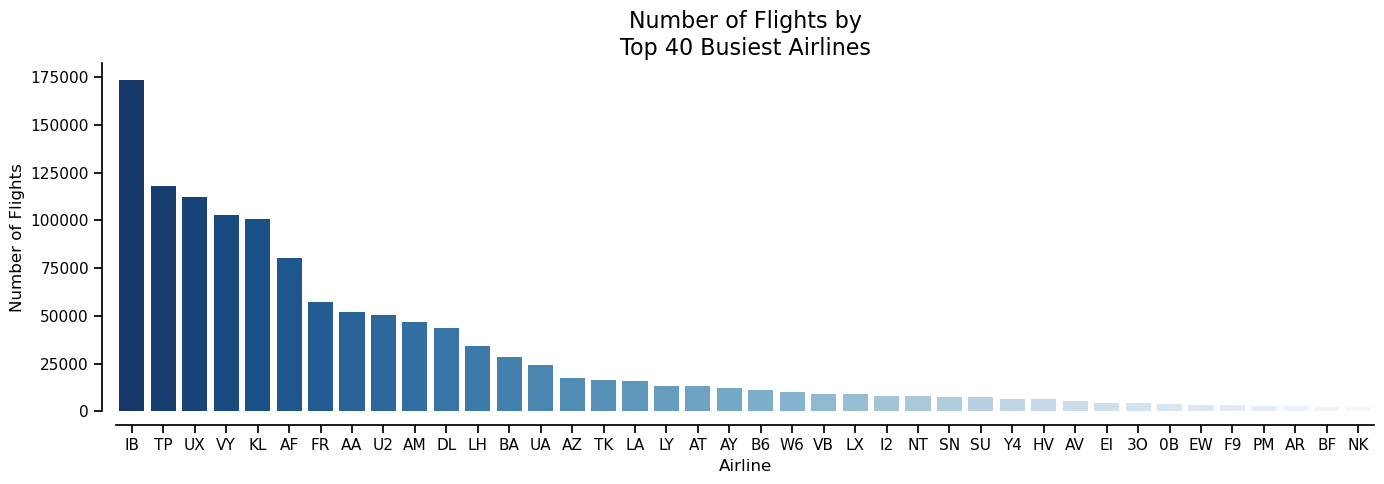

In [144]:
airlines_counts = flights.groupby('airline')['airline'].count()
busiest_airlines = airlines_counts.sort_values(ascending=False).head(40)

# plot
plt.figure(figsize=(14,5))
sns.barplot(x=busiest_airlines.index, y=busiest_airlines, palette='Blues_r')
plt.title('Number of Flights by\nTop 40 Busiest Airlines', fontsize=16)
plt.xlabel('Airline');
plt.ylabel('Number of Flights')
sns.despine(offset=10)
plt.tight_layout()

In [187]:
# group by flight
pf_agg = pf.groupby(['orig-dest','dDate', 'dTime', 'aTime', 'flight_no', 'airline'])[['log_price']].mean().reset_index()

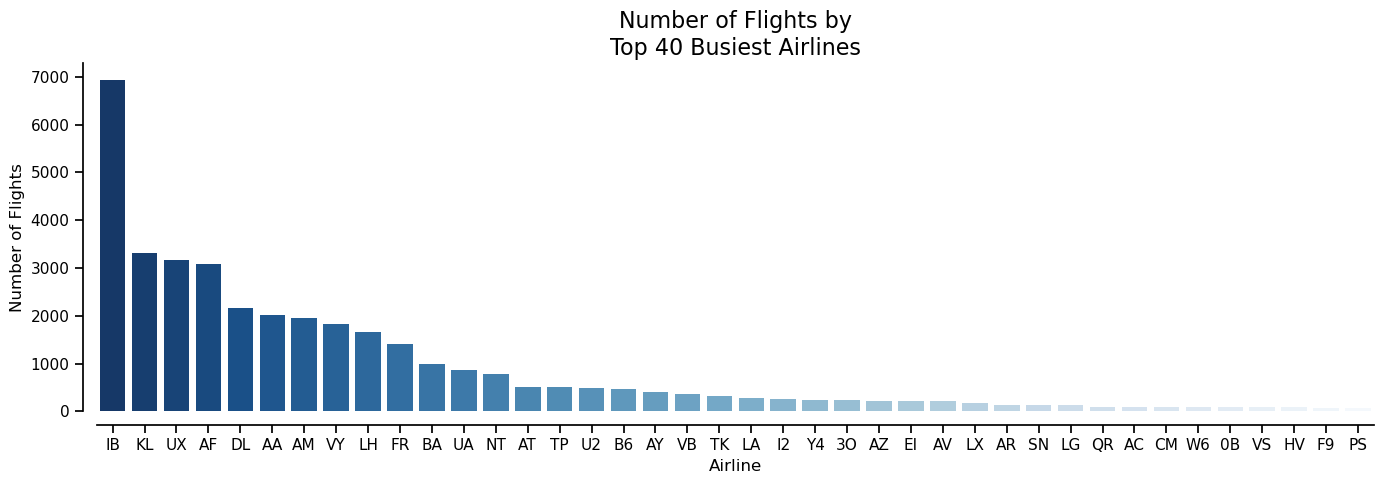

In [190]:
airlines_counts = pf_agg.groupby('airline')['airline'].count()
busiest_airlines = airlines_counts.sort_values(ascending=False).head(40)

# plot
plt.figure(figsize=(14,5))
sns.barplot(x=busiest_airlines.index, y=busiest_airlines, palette='Blues_r')
plt.title('Number of Flights by\nTop 40 Busiest Airlines', fontsize=16)
plt.xlabel('Airline');
plt.ylabel('Number of Flights')
sns.despine(offset=10)
plt.tight_layout()

### Flight_no

In [205]:
pf['flight_no'].head()

0    UX7703
1    VY1003
2    IB1946
3    UX6097
4    UX6067
Name: flight_no, dtype: object

* flight_no identifies a unique plain. Using this variable we can show price evolution a concrete flight through days. For example:

In [204]:
pf['flight_no'].nunique()

2902

In [203]:
pf.groupby('flight_no')['orig-dest'].nunique().describe()

count    2902.000000
mean        1.649897
std         1.131221
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: orig-dest, dtype: float64

Each plain travels through an average of 1.64 routes. This means that there are plains transiting more than one route.

### Fly_duration

In [33]:
flights['fly_duration'].head()

0     1.416667
1     1.250000
2     1.333333
3    13.583333
4    18.000000
Name: fly_duration, dtype: float64

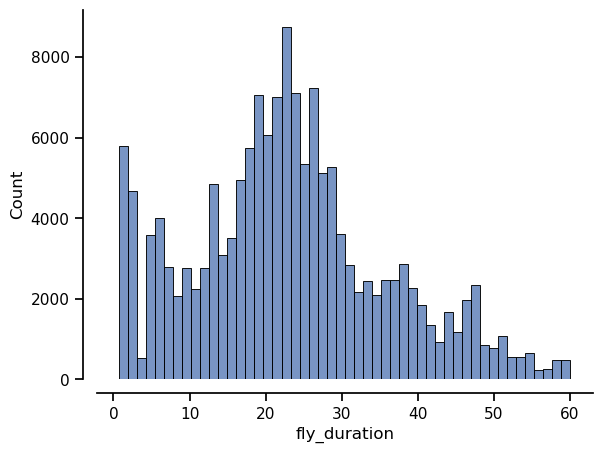

In [210]:
sns.histplot(pf['fly_duration'], bins=50);
sns.despine(offset=10)

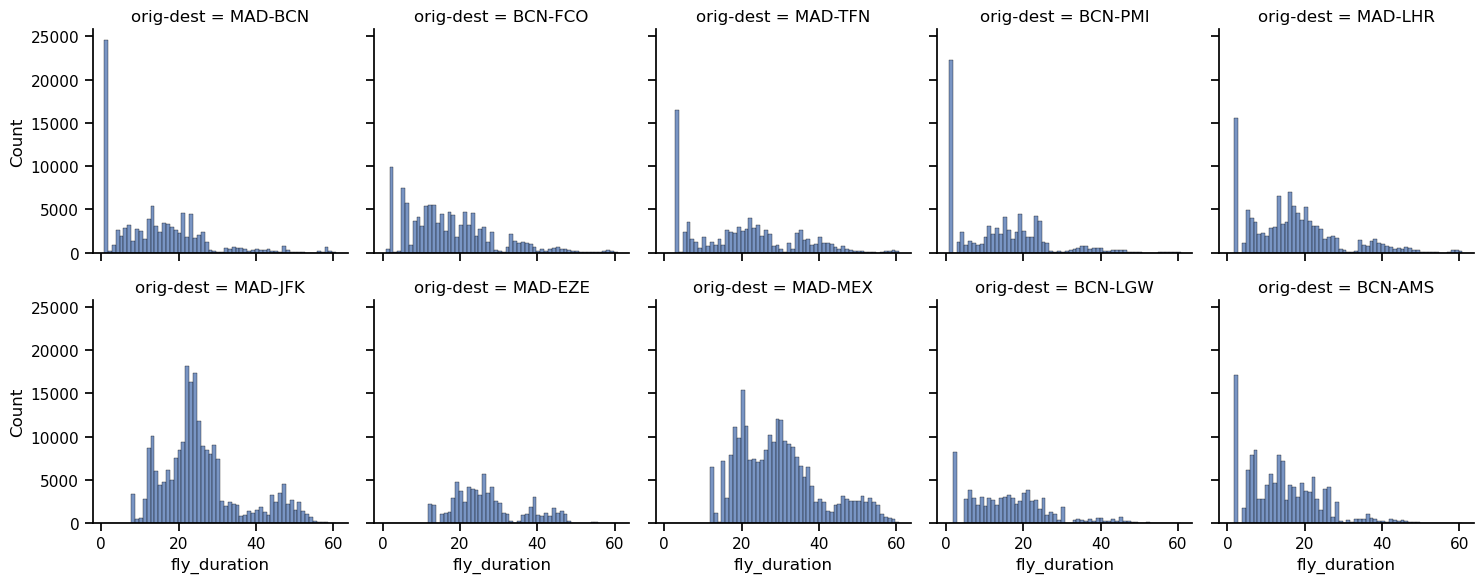

In [216]:
# Price distribution for route
sns.displot(
    flights, x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3
);
plt.tight_layout()

* It seems that there are variability in the fly_duration variable even in flights on the same route.
* We can notice that in some routes a considerable number of flights concentreates in some point on the left side. These are probable direct flights.

In [289]:
# Direct flights
flights['hops'] = flights['route'].apply(lambda x: len(x.split('->')) - 2)
flights['direct'] = flights['hops'] == 0

In [290]:
# There are observations with wrong column due an error during collection. We'll drop them.

split_date = datetime.strptime('2021-02-24', '%Y-%m-%d')
broken = pd.to_datetime(flights['collectionDate']) < split_date

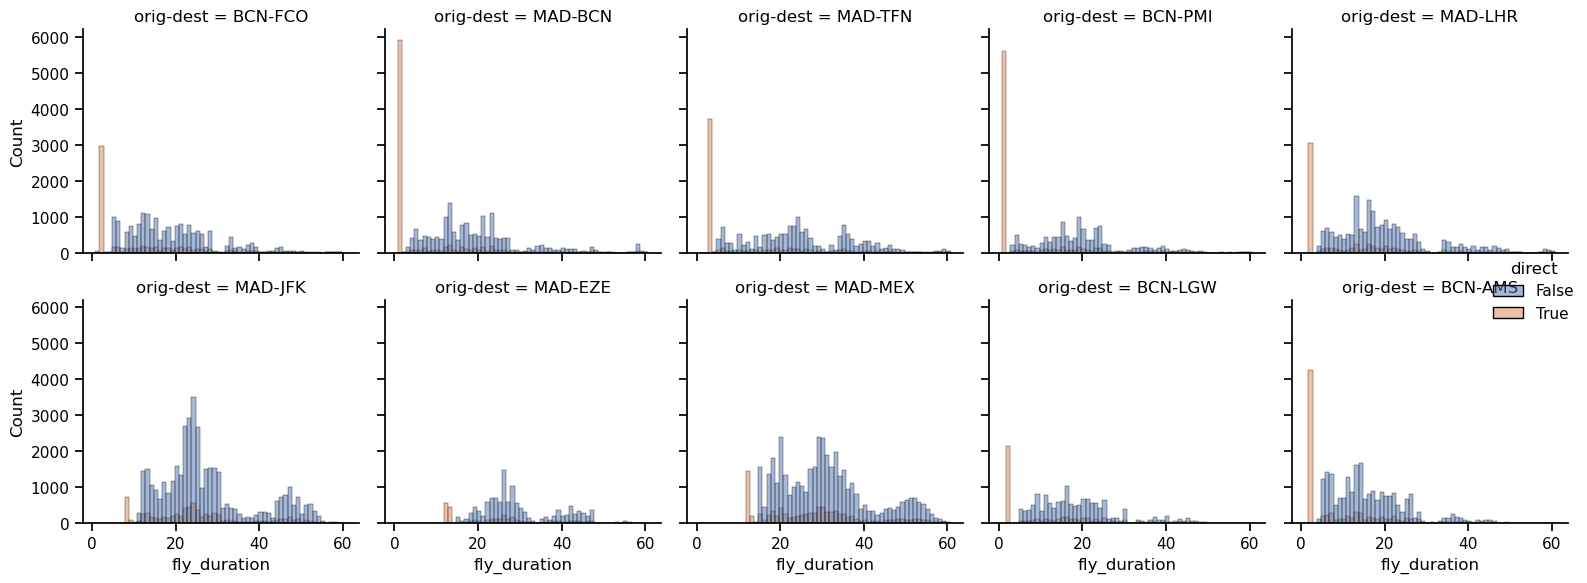

In [301]:
# Price distribution for route
g = sns.displot(
    flights[~broken], x="fly_duration", col="orig-dest", col_wrap=5, kind='hist',
    binwidth=1, height=3, hue='direct', facet_kws={"legend_out": True}
);
plt.tight_layout()

* Now we can clearly distinguish between direct flights and flights with hopping in the fly_duration distributions now

### Distance

* Distance is fixed for each route

### Route

In [36]:
# TODO: route col broken in flights collected before 24 feb. USE airlines length-1 instead

In [37]:
flights['route'].head()

0    MAD -> BCN
1    MAD -> BCN
2    MAD -> BCN
3    MAD -> BCN
4    MAD -> BCN
Name: route, dtype: object

* This variable shows the hops in a flight route between origin and destination
* We can use this to create a new columns that computes the number of hops

In [38]:
flights['hopping'] = flights['airlines'].apply(lambda x: x.split()).apply(len)-1

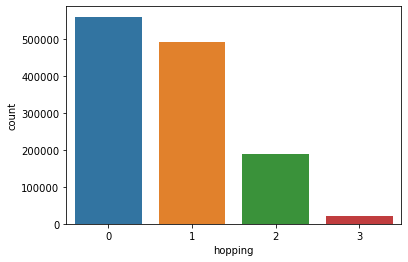

In [39]:
sns.countplot(flights['hopping']);

### Seats

In [40]:
flights['seats'].isna().sum()

292281

In [41]:
flights['seats'].isna().sum() / flights.shape[0]

0.2308313786812614

* This column has many NaN values (21.19%).

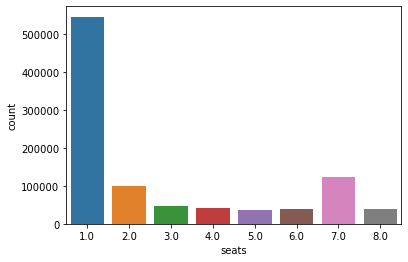

In [42]:
sns.countplot(flights['seats']);

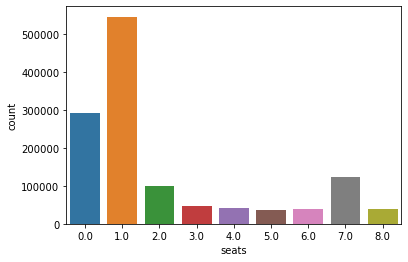

In [43]:
sns.countplot(flights['seats'].fillna(0));

## collectionDate and daysToDep

We can use 'collectionDate' column to compute days until the flight departure. This would be a new numerical variable.

In [44]:
collected = pd.to_datetime(flights['collectionDate'])
departure =  pd.to_datetime(flights['dDate'])

daysToDep = departure - collected
daysToDep = daysToDep.apply(lambda x: str(x).split()[0])

In [45]:
flights['daysToDep'] = daysToDep.astype(int)

## Multivariate Analysis

In [46]:
corr_mat = flights.corr()
corr_mat['price'].sort_values(ascending=False)

price           1.000000
log_price       0.711591
distance        0.363309
fly_duration    0.195374
hopping         0.185394
daysToDep      -0.028653
seats          -0.052996
Name: price, dtype: float64

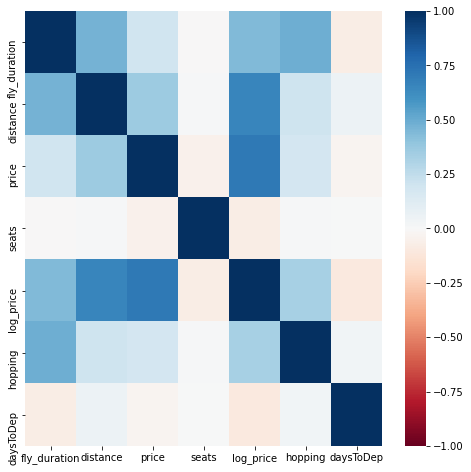

In [47]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap='RdBu', annot=False);

### Price-CollectionDate

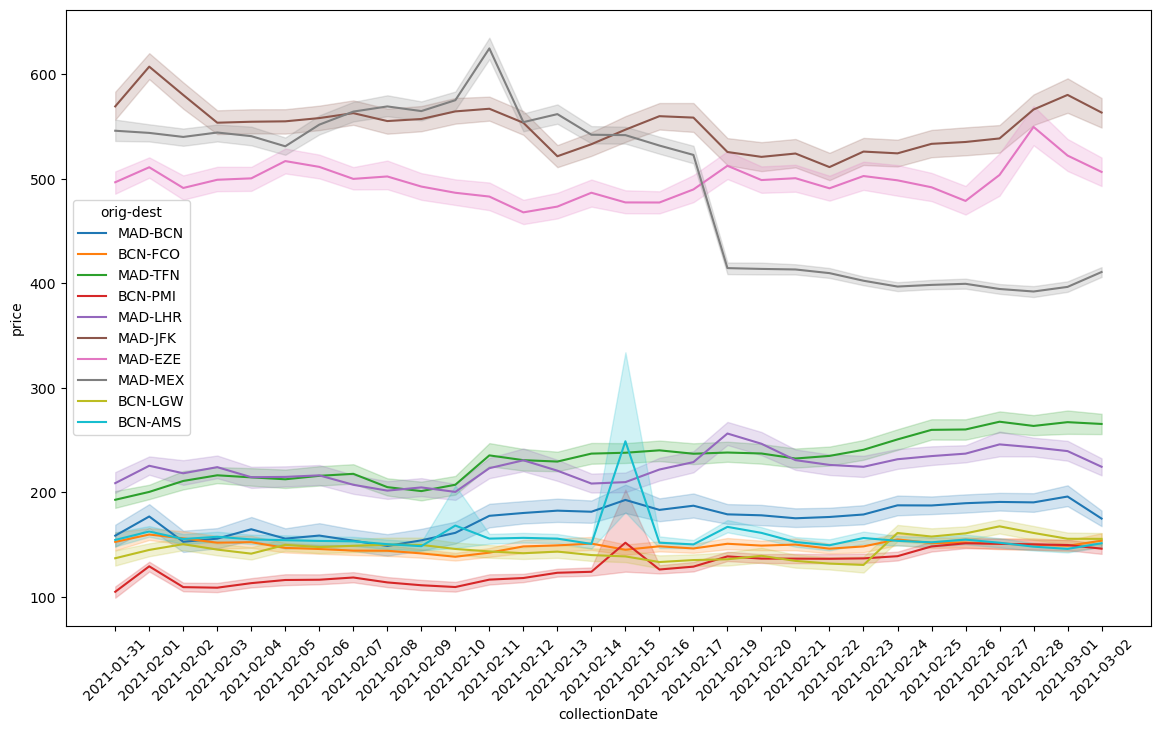

In [105]:
plt.subplots(figsize=(14,8))
sns.lineplot(x='collectionDate', y='price', data=flights, hue='orig-dest');
plt.xticks(rotation=45);

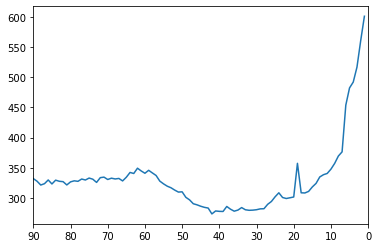

In [49]:
# mean price by remaining days to departure
grouped= flights.groupby('daysToDep')['price'].mean()
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);

* The mean price start to decrease around two month before flight departure, reach its minimum at one month, and start increasing two/three weeks before departure.

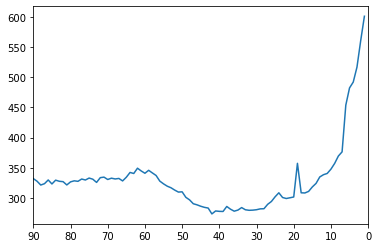

In [50]:
# mean price by remaining days to departure
flights['hoursUntilDep'] = flights['daysToDep']

grouped= flights.groupby('daysToDep')['price'].mean()
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);

In [51]:
flights['flight_no'].head()

0    UX7703
1    VY1003
2    IB1946
3    UX6097
4    UX6067
Name: flight_no, dtype: object

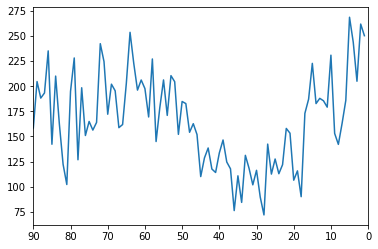

In [52]:
flights_sample = subset_flights(flights, flight_no='UX7703')
grouped= flights_sample.groupby('daysToDep')['price'].mean()
plt.plot(grouped);
plt.xlim(grouped.index.max(), 0);

## Price-Distance

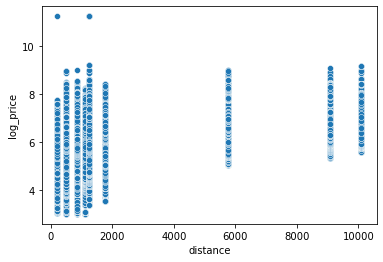

In [53]:
sns.scatterplot(x='distance', y='log_price', data=flights);

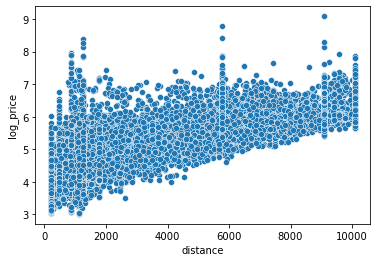

In [54]:
grouped = flights.groupby(['dDate', 'dTime'])[['distance','log_price']].mean()
sns.scatterplot(x='distance', y='log_price', data=grouped);

* Here we can see how price increases by distance.

## Price-Airlines

## Price-Seats